# Introduction to Data Science

# The CRISP-DM approach to Data Science Tasks

_________________________

# Business Understanding

                    
### The Business Understanding phase focuses on understanding the objectives and requirements of the project.  
+ Determine business objectives:  

O objetivo do nosso projeto é entender quais são os fatores que influenciam os jovens e a educação brasileira. Utilizando os dados do INEP (Instituto Nacional de Estudos e Pesquisas Educacionais), podemos coletar o município, uf, média de alunos por turma, a taxa de reprovação, a taxa de abandono, a situação socio-econômica e diversas outras informações sobre o Ensino Médio de milhares de escolas ao redor do país e usar isso pra nos ajudar a compreender o que está por trás de uma educação de sucesso (ou não).

+ Assess situation:  

A educação brasileira é extremamente heterogênea, contando desde escolas de elite, com atividades complementares e baixa quantidade de aluno por professor, até escolas públicas cujo corpo docente nem sempre possui a formação acadêmica necessária pra matéria que dá aula. Os dados para pesquisas desse nível são extremamente extensos e de fácil acesso, porém de fonte única (INEP), vez que são coletados pelo governo e disponibilizados para a população de forma gratuita e transparente.

+ Determine data mining goals: 

Coletar os dados sobre as escolas do ensino médio brasileiro, pra saber se elas são públicas ou privadas, urbanas ou rurais, medidas que comprovem  o engajamento do corpo discente com a educação (taxa de abandono, de reprovação) e a qualificação do corpo doscente. Todos esses dados são disponibilizados pelo INEP.

+ Produce project plan:  
    + Coletar os Indicadores Educacionais do INEP.

    + Entender os dados, explorá-los e descrevê-los. 

    + Verificar quais são as tabelas e colunas relevantes para os objetivos e se desfazer do restante.

    + Filtrar os dados, selecionando apenas escolas do ensino médio.

    + Observar a correlação entre as variáveis e a taxa de abandono/taxa de reprovação.

    + Construir um modelo que preveja a taxa de abandono e reprovação de uma escola, baseando-se nos outros dados obtidos.

    + Separar os nossos dados em treino e teste, utilizando o treino para treinar o modelo e o teste para avaliar as previsões.

    + Fazer o relatório final e revisar o projeto.



In [1]:
# aquisição dos dados
import basedosdados as bd
import requests
from bs4 import BeautifulSoup as bs
import numpy as np

# visualização
from matplotlib import pyplot as plt
import seaborn as sns

# manipulação
import pandas as pd
import pickle
from sklearn import preprocessing

# Data Understanding  

+ Collect initial data:  
+ Describe data:  
+ Explore data:  
+ Verify data quality:  

## Collect initial data:  

In [2]:
# Define algumas variáveis úteis
dataset_id = "br_inep_indicadores_educacionais"
billing_project_id="trabalho-amd"

Download das tabelas do dataset:
(o código comentado baixa do site os .csv)

In [3]:
# bd.download(dataset_id=dataset_id, table_id='escola', savepath='data/escola.csv', billing_project_id=billing_project_id)
df_escola = pd.read_csv('data/escola.csv')
df_escola_em = pd.read_pickle('df_escola_em.pkl')

Como pode ser justificado na sessão *Describe Data*, o dataset `escola.csv` tem apenas a coluna `id_municipio`, porém nenhum identificador de qual município é aquele nem qual a sua UF. <br>
O IBGE classifica cada município com um código de 7 dígitos onde os dois primeiros representam a UF (referência: <https://www.ibge.gov.br/explica/codigos-dos-municipios.php>). <br>
Como queremos analisar os dados por UF também, realizamos o scrapping dos códigos das UF presentes no link acima, mais para fins de aprendizado do que por questões práticas já que se tratavam de poucos dados.

In [4]:
html = requests.get("https://www.ibge.gov.br/explica/codigos-dos-municipios.php")
soup = bs(html.text)

# seleciona a tag table
table = soup.find('table')

# extrai o nome das colunas da tabela
column_names = []
for name in table.find('tr'):
    if name != "\n":
        column_names.append(name.text)

# extrai as linhas da tabela
trows = soup.find('tbody').find_all('tr')
tcols = []

# itera sobre as linhas
for tr in trows:
    # cria uma lista das colunas dessa linha
    col = tr.find_all('td')
    uf = col[0].text
    code = int(col[1].text.replace('ver municípios', ''))
    tcols.append([uf, code])

df_codigos_uf = pd.DataFrame(tcols, columns = column_names)
df_codigos_uf.head()

,UFs,Códigos
0,Acre,12
1,Alagoas,27
2,Amapá,16
3,Amazonas,13
4,Bahia,29


## Describe Data

Começando pela tabela `escola` que é a mais importante do dataset, podemos ver que ela é formada por 208 colunas, destas 205 numéricas e 3 categóricas.

Algumas colunas notáveis são:
+ **rede:** 

municipal, estadual, federal ou privada;

+ **localização:**

urbana ou rural;

+ **atu**: Média de Alunos por Turma:

Quociente entre a matrícula total e o total de turmas da escola;

+ **had**: Média de Horas-Aula diária:

Tempo médio de permanência do aluno na escola;

+ **tdi**: Taxa de distorção idade-série:

Percentual de alunos, em cada série, com idade superior à recomendada. No Brasil, a idade recomendada para o ingresso no ensino médio ($1^o$ ano) é de 15 anos;

+ **taxa_aprovação/taxa_reprovação**:

Percentual de alunos aprovados/reprovados naquela determinada série;

+ **taxa_abandono**:

Percentual de alunos que abandonaram os estudos;

+ **dsu**: Percentual de Docentes com Curso Superior:

Indicador do nível de formação dos docentes em exercício;

+ **afd**: Adequação da Formação Docente:

Classificação do docente de acordo com a adequação de sua formação às disciplinas que leciona, ou seja, considera os professores que são formados em licenciatura na área da disciplina que leciona.

+ **ird_media_regularidade_docente**: Regularidade do corpo docente nas escolas de educação básica:

Avaliação da regularidade do corpo docente em um período de 5 anos. O IRD varia de 0 a 5, sendo que quanto mais próximo de 0, mais irregular é o docente, e quanto mais próximo de 5, mais regular ele é;

+ **id_municipio**:

Código do município no IBGE, o código é composto por 7 dígitos onde os dois primeiros indicam a Unidade Federativa a qual ele pertence;

+ **tnr**: 

Taxa de não resposta.

Referência para a explicação de cada índice:
<http://www.gestaouniversitaria.com.br/artigos/conheca-os-indicadores-que-detalham-as-tendencias-da-educacao-basica-brasileira>

In [5]:
df_escola.info()
df_escola.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2637557 entries, 0 to 2637556
Columns: 208 entries, ano to icg_nivel_complexidade_gestao_escola
dtypes: float64(202), int64(3), object(3)
memory usage: 4.1+ GB


,ano,id_municipio,rede,id_escola,localizacao,atu_ei,atu_ei_creche,atu_ei_pre_escola,atu_ef,atu_ef_anos_iniciais,...,ied_ef_anos_finais_nivel_4,ied_ef_anos_finais_nivel_5,ied_ef_anos_finais_nivel_6,ied_em_nivel_1,ied_em_nivel_2,ied_em_nivel_3,ied_em_nivel_4,ied_em_nivel_5,ied_em_nivel_6,icg_nivel_complexidade_gestao_escola
0,2013,1100015,municipal,11024542,rural,NaN,NaN,NaN,5.0,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,nivel 1
1,2013,1100015,municipal,11025000,rural,NaN,NaN,NaN,6.0,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,nivel 1
2,2013,1100015,municipal,11025115,rural,11.0,NaN,11.0,13.0,NaN,...,30.8,7.7,7.7,NaN,NaN,NaN,NaN,NaN,NaN,nivel 2
3,2013,1100015,municipal,11047461,urbana,19.3,NaN,19.3,20.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nivel 2
4,2013,1100023,municipal,11007850,rural,NaN,NaN,NaN,18.1,17.2,...,71.4,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,nivel 3
5,2013,1100023,estadual,11048620,urbana,NaN,NaN,NaN,29.9,27.8,...,33.3,44.4,5.6,0.0,0.0,0.0,46.6,46.7,6.7,nivel 6
6,2013,1100023,municipal,11007931,urbana,26.1,NaN,26.1,27.7,27.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nivel 5
7,2013,1100049,municipal,11026294,rural,13.0,NaN,13.0,17.1,17.6,...,42.9,0.0,14.3,NaN,NaN,NaN,NaN,NaN,NaN,nivel 2
8,2013,1100049,estadual,11026014,urbana,NaN,NaN,NaN,19.0,19.8,...,71.4,14.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,nivel 3
9,2013,1100049,estadual,11026545,urbana,NaN,NaN,NaN,27.5,27.4,...,33.3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,nivel 3


# Data Preparation

+ Select data:   
+ Clean data:   
+ Construct data/transform data/feature engineering:   
+ Integrate data:   
+ (Re) Format data:   

A ideia é apenas trabalhar com os dados do ensino médio. Então filtramos as colunas `id_escola`, `ano`, `id_municipio`, `rede` e `localizacao` além de todas aquelas que possuem a substring 'em' (referente à ensino médio) em seu nome.

Após isso removemos todas as linhas que não possuíam dados (preenchidas com `Nan`) na coluna `taxa_aprovacao_em`, ou seja, as escolas que não tinha registros referentes ao ensino médio já que atuam em outros níveis de educação.

In [6]:
# seleciona as colunas relacionadas ao EM (apenas as gerais, e não as separadas por ano)
em_cols = [ 'id_escola', 'id_municipio', 'taxa_aprovacao_em', 'taxa_reprovacao_em', 'taxa_abandono_em',
            'ano', 'rede', 'localizacao', 
            'atu_em', 'had_em', 'tdi_em', 'dsu_em']

# redefine o dataset apenas com essas colunas
df_escola_em = df_escola[em_cols]

# remove as linhas que não tem dados do EM (consideramos que se não há taxa de aprovação, a escola não tem EM)
df_escola_em = df_escola_em.dropna(subset=['taxa_aprovacao_em'])

# redefine o index do dataframe
df_escola_em.index = range(df_escola_em.shape[0])

In [7]:
regions = []
regions_dict = {'Norte': 1, 'Nordeste': 2, 'Sudeste': 3, 'Sul': 4, 'Centro-Oeste': 5}

for index, row in df_escola_em.iterrows():
    # extrai o ID da região (2 primeiros dígitos do ID município)
    id_uf = int(str(row['id_municipio'])[0])
    for key in regions_dict:
        if id_uf == regions_dict[key]:
            regions.append(key)

# transforma a lista em um objeto do tipo Series
regions = pd.DataFrame(pd.Series(regions), columns = ['regiao'])

# concatena os datasets
df_escola_em = pd.concat([df_escola_em, regions], axis=1)

In [8]:
# # transforma id_escola no índice do df:
# df_escola_em.set_index(df_escola_em['id_escola'])

 # remove id_municipio
df_escola_em = df_escola_em.drop(['id_municipio'], axis = 1)

In [9]:
df_escola_em.info(show_counts=True)
df_escola_em.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350586 entries, 0 to 350585
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id_escola           350586 non-null  int64  
 1   taxa_aprovacao_em   350586 non-null  float64
 2   taxa_reprovacao_em  350586 non-null  float64
 3   taxa_abandono_em    350586 non-null  float64
 4   ano                 350586 non-null  int64  
 5   rede                350586 non-null  object 
 6   localizacao         350586 non-null  object 
 7   atu_em              350062 non-null  float64
 8   had_em              276085 non-null  float64
 9   tdi_em              343085 non-null  float64
 10  dsu_em              250120 non-null  float64
 11  regiao              350586 non-null  object 
dtypes: float64(7), int64(2), object(3)
memory usage: 32.1+ MB


,id_escola,taxa_aprovacao_em,taxa_reprovacao_em,taxa_abandono_em,ano,rede,localizacao,atu_em,had_em,tdi_em,dsu_em,regiao
0,11048620,66.7,26.4,6.9,2013,estadual,urbana,24.7,4.1,34.5,93.3,Norte
1,11027401,77.2,7.0,15.8,2013,estadual,urbana,22.2,4.8,40.5,100.0,Norte
2,11036125,95.0,0.0,5.0,2013,estadual,rural,18.3,4.3,30.9,85.7,Norte
3,11049014,98.3,1.7,0.0,2013,privada,rural,30.0,8.5,25.0,100.0,Norte
4,11017775,72.6,12.2,15.2,2013,estadual,urbana,27.4,4.2,41.0,100.0,Norte
5,11000937,83.5,5.3,11.2,2013,estadual,urbana,35.0,4.3,32.6,100.0,Norte
6,11038063,62.0,5.1,32.9,2013,estadual,urbana,32.8,4.8,53.4,100.0,Norte
7,11107804,82.8,16.7,0.5,2013,federal,urbana,23.7,4.4,12.9,100.0,Norte
8,11041951,98.5,1.5,0.0,2013,privada,urbana,22.7,5.3,2.9,100.0,Norte
9,11004428,91.4,8.6,0.0,2013,estadual,urbana,33.3,4.3,31.9,91.7,Norte


E por fim, temos o dataset filtrado contendo **350.586** entradas e **25** colunas.

## Tratamento de Dados
Primeiramente substituímos os valores de `atu_em` (média de alunos por turma) que fossem superiores a `50` por `Nan` por se acreditar que se tratavam de *outliers*. A escolha do número foi considerando o [limite por lei máximo de 40 alunos por turma](sinprors.org.br/arquivos/6_6_2016_limite_de_alunos.pdf) + 25% desse valor. Ao todo, `2607` colunas foram afetadas por este processo.

Então preenchemos os valores faltantes com a mediana nos casos de *horas diárias* e *média de alunos por turma*. (terminar explicação)

In [10]:
# substitui os dados que contém mais de 50 alunos por turma
df_escola_em.loc[df_escola_em['atu_em'] > 50, 'atu_em'] = np.nan

# preenche os valores faltantes
for col in ['had_em', 'atu_em', 'dsu_em', 'tdi_em']:
    df_escola_em[col] = df_escola_em[col].fillna(df_escola_em[col].mean())

df_escola_em.to_pickle("df_escola_em.pkl")

In [11]:
df_escola_em = pd.read_pickle('df_escola_em.pkl')

## Normalizando os dados

In [12]:
taxas = ['tdi_em', 'taxa_aprovacao_em', 'taxa_reprovacao_em', 'taxa_abandono_em', 'dsu_em']

for tx_col in taxas:
    df_escola_em[tx_col] = df_escola_em[tx_col].apply(lambda x: x/100)

for col in ['had_em', 'atu_em']:
    min_val = df_escola_em[col].min()
    max_val = df_escola_em[col].max()
    df_escola_em[col] = df_escola_em[col].apply(lambda x: (x-min_val)/(max_val-min_val))

# normaliza ano
df_escola_em['ano'] = df_escola_em['ano'].apply(lambda x: x - df_escola_em['ano'].min())

## Gerando o dataset com Dummies
de modo a podermos tratar numericamente as variáveis categóricas na hora de elaborar os modelos, geramos um dataframe auxiliar com os dummies.

In [13]:
df_escola_em_dummies = pd.get_dummies(df_escola_em)
df_escola_em_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350586 entries, 0 to 350585
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id_escola            350586 non-null  int64  
 1   taxa_aprovacao_em    350586 non-null  float64
 2   taxa_reprovacao_em   350586 non-null  float64
 3   taxa_abandono_em     350586 non-null  float64
 4   ano                  350586 non-null  int64  
 5   atu_em               350586 non-null  float64
 6   had_em               350586 non-null  float64
 7   tdi_em               350586 non-null  float64
 8   dsu_em               350586 non-null  float64
 9   rede_estadual        350586 non-null  uint8  
 10  rede_federal         350586 non-null  uint8  
 11  rede_municipal       350586 non-null  uint8  
 12  rede_privada         350586 non-null  uint8  
 13  localizacao_rural    350586 non-null  uint8  
 14  localizacao_urbana   350586 non-null  uint8  
 15  regiao_Centro-Oes

In [14]:
df_escola_em_dummies.to_pickle('df_escola_em_dummies.pkl')

# Data Exploration

## Gráfico de Correlação com todos os dados

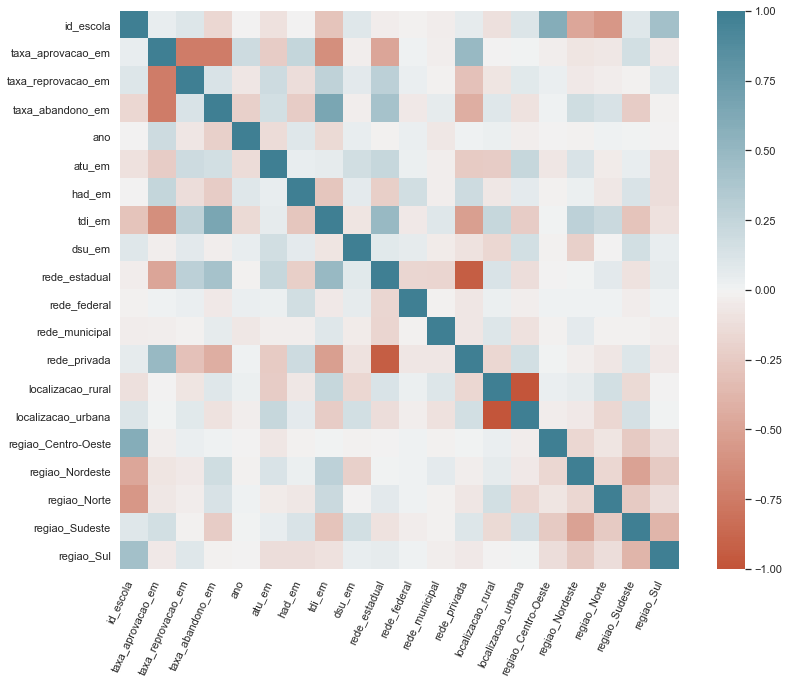

In [15]:
corr = df_escola_em_dummies.corr()
sns.set(rc={'figure.figsize':(13.7,10.27)})

ax = sns.heatmap(   corr, 
                    vmin=-1, vmax=1, center=0, 
                    cmap=sns.diverging_palette(20, 220, n=200), 
                    square=True
                )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=65,
    horizontalalignment='right'
);

## Matriz de Correlação com as variáveis categóricas
Podemos notar algumas correlações importantes, como entre taxa de aprovação e rede da escola, taxa de aprovação sendo negativamente correlacionada com taxa de distorção de idade, que é positivamente correlacionado com reprovações e abandonos e também podemos observar que a quantidade de horas em sala de aula gera uma maior taxa de aprovação e uma menor taxa de abandono e reprovação. Além disso podemos notar que a localização da escola pouco influencia em grande parte dos índices.

## Média de Aprovações por rede e localização:
podemos observar que a aprovação em média não difere tanto quanto à escola estar em área urbana ou rural, porém a aprovação média da rede privada chega a ser 10% a mais que das redes públicas.

        rede localizacao  taxa_aprovacao_em
0   estadual       rural           0.834630
1   estadual      urbana           0.791003
2    federal       rural           0.844321
3    federal      urbana           0.851495
4  municipal       rural           0.821779
5  municipal      urbana           0.807319
6    privada       rural           0.921513
7    privada      urbana           0.943943


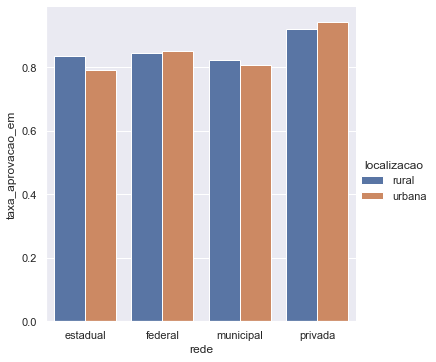

In [16]:
media_aprovacao = df_escola_em[['taxa_aprovacao_em', 'rede', 'localizacao']].groupby(['rede', 'localizacao'], as_index=False).mean()
print(media_aprovacao)
sns.catplot(
    x = 'rede',
    y = 'taxa_aprovacao_em',
    hue = 'localizacao',
    kind = 'bar',
    data = media_aprovacao
);

## Média de reprovações por rede e localização
Já a média de reprovações é mais influenciada por localização e rede, tendo mais reprovações em áreas urbanas e uma taxa de reprovações mais alta na rede federal.

        rede localizacao  taxa_reprovacao_em
0   estadual       rural            0.071909
1   estadual      urbana            0.117136
2    federal       rural            0.116986
3    federal      urbana            0.120365
4  municipal       rural            0.064033
5  municipal      urbana            0.093384
6    privada       rural            0.035759
7    privada      urbana            0.050397


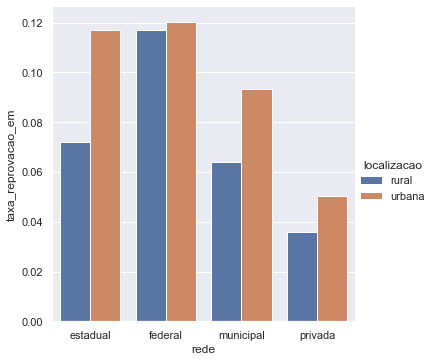

In [17]:
media_reprovacao = df_escola_em[['taxa_reprovacao_em', 'rede', 'localizacao']].groupby(['rede', 'localizacao'], as_index=False).mean()
print(media_reprovacao)
sns.catplot(
    x = 'rede',
    y = 'taxa_reprovacao_em',
    hue = 'localizacao',
    kind = 'bar',
    data = media_reprovacao
);

## Média da taxa de abandono por rede e localização
É notável uma grande diferença entre rede rural e urbana, isso provavelmente devido à muitos estudantes no ensino médio precisarem trabalhar com a família na agricultura. Além disso, a rede privada tem uma taxa de abandono bem reduzida em áreas urbanas (menor que 1%) e a rede federal é dentre as públicas a que menos alunos abandonam a escola

## Média de abandono ao longo do tempo
Analisando a média de abandono ao longo do tempo, podemos ver que, num geral, ela teve uma queda considerável nos últimos anos, principalmente nas redes municipal e estadual.

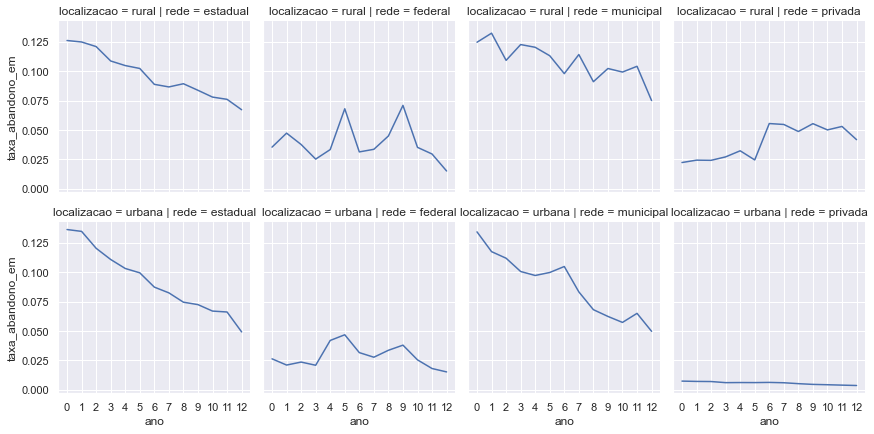

In [18]:
media_abandono = df_escola_em[['taxa_abandono_em', 'rede', 'localizacao', 'ano']].groupby(['ano', 'rede', 'localizacao'], as_index=False).mean()
media_abandono["ano"] = media_abandono["ano"].astype('str')
sns.relplot(x=media_abandono['ano'], y=media_abandono["taxa_abandono_em"],
            col=media_abandono["rede"], row=media_abandono["localizacao"], height=3,
            estimator=None, data=media_abandono, kind = "line");

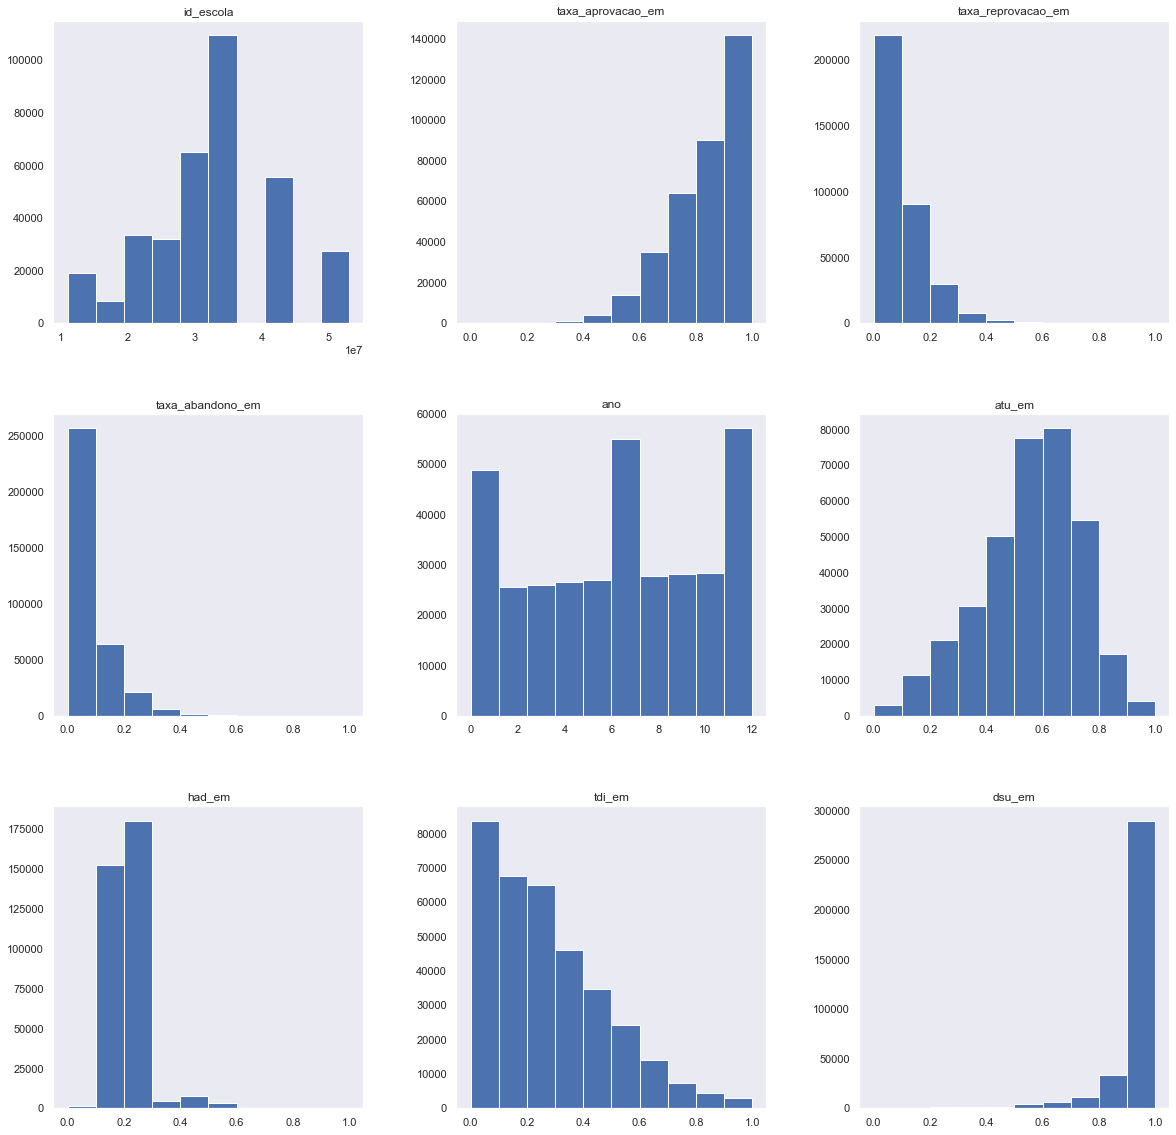

In [19]:
df_escola_em.hist(bins = 10, figsize=(20, 20), grid=False, sharex = False, sharey=False);

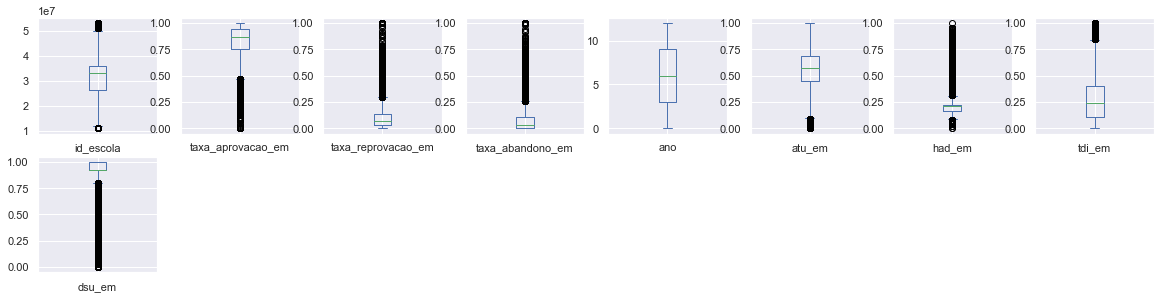

In [20]:
df_escola_em.plot(kind='box', subplots=True, layout=(8, 8), sharex=False, sharey=False, figsize=(20, 20));

## Verificar a qualidade dos dados
Os dados foram adquiridos do INEP, portanto não há preocupação quanto a veracidade dos mesmos pois são dados oficiais. Quanto a dados faltantes, há uma quantidade considerável de dados em branco referente às métricas `afd` e `ied`, que possuem apenas 196.331 das 350586 entradas.

Além disso, há uma pequena redução na quantidade de entradas das 3 taxas (aprovação, reprovação e abandono) do primeiro para o segundo ano (redução de 6703 entradas) e do segundo para o terceiro (redução de 7242 entradas), redução a qual atribuímos a fundação de novas escolas no período analisado, que, portanto, não teriam dados de aprovação em todos os anos do ensino médio. Por exemplo, institutos federais tem ingresso apenas no primeiro ano.

# Modeling

+ Select modeling techniques: 
+ Generate test design: 
+ Build model: 
+ Assess model:  

In [21]:
# modelos
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, RidgeCV, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor


# seleção de modelos
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# train test split
from sklearn.model_selection import train_test_split

# normalização
from sklearn.preprocessing import MinMaxScaler

seed = 1

df_escola_em_dummies = pd.read_pickle('df_escola_em_dummies.pkl')

In [45]:
# separa em X e y
X = df_escola_em_dummies
ys = {}

ys['aprovacao'] = df_escola_em_dummies['taxa_aprovacao_em']
X = X.drop('taxa_aprovacao_em', axis = 1)

ys['reprovacao'] = df_escola_em_dummies['taxa_reprovacao_em']
X = X.drop('taxa_reprovacao_em', axis = 1)

ys['abandono'] = df_escola_em_dummies['taxa_abandono_em']
X = X.drop('taxa_abandono_em', axis = 1)

X = X.drop('id_escola', axis = 1)

In [24]:
models = []

models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('EN', ElasticNet(random_state=seed)))
#models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('RIDGE', Ridge(random_state=seed)))
models.append(('RIDGECV', RidgeCV()))
models.append(('MLPR', MLPRegressor(random_state=seed)))
models.append(('GPR', GaussianProcessRegressor(random_state=seed)))
models.append(('SGD', SGDRegressor(random_state=seed)))
# models.append(('SVR', SVR()))


In [25]:
results = []
names = []
num_folds = 2
score = 'r2'

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=score)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) 


LR: 0.495467 (0.000450)
LASSO: 0.001977 (0.000139)
EN: 0.001977 (0.000139)
CART: 0.209977 (0.001220)
RIDGE: 0.495467 (0.000450)
RIDGECV: -3331454.363465 (2847300.073881)
MLPR: -1926365.791945 (1807573.909972)
GPR: nan (nan)
SGD: -528475257162667998231007794303345997961788129280.000000 (401827435398955886955143290870263436341866921984.000000)


In [35]:
def get_random_forest(X, y):
    n_estimators_values=np.array([30,50,70])
    min_samples_split_values = [2,3]
    min_samples_leaf_values = [10,20,30]

    param_grid = dict(n_estimators=n_estimators_values,
                    min_samples_split=min_samples_split_values, 
                    min_samples_leaf=min_samples_leaf_values)

    model = RandomForestRegressor(random_state=None, n_jobs=-1)
    kfold = KFold(n_splits=num_folds, random_state=None)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring=score, cv=kfold)
    grid_result = grid.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    return grid_result.best_estimator_

In [46]:
models = {}
for key in ys:
    models[key] = get_random_forest(X, ys[key])
    print('\n\n')
models

Best: 0.561024 using {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 20}
0.556860 (0.000327) with: {'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 10}
0.559131 (0.000061) with: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 10}
0.560454 (0.000310) with: {'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 20}
0.560337 (0.000294) with: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 20}
0.559509 (0.000121) with: {'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 30}
0.561024 (0.000008) with: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 20}
0.557265 (0.000469) with: {'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 10}
0.558480 (0.000109) with: {'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 10}
0.559587 (0.000523) with: {'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 30}
0.559830 (0.000155) with: {'n_estimators': 30, 'min_sam

{'aprovacao': RandomForestRegressor(min_samples_leaf=20, n_estimators=70, n_jobs=-1),
 'reprovacao': RandomForestRegressor(min_samples_leaf=30, n_estimators=70, n_jobs=-1),
 'abandono': RandomForestRegressor(min_samples_leaf=30, n_estimators=70, n_jobs=-1)}

## V. Evaluation                    

+ Evaluate results: 
+ Review process: 
+ Determine next steps: 

In [31]:
importances = list(model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: tdi_em               Importance: 0.56
Variable: id_escola            Importance: 0.15
Variable: rede_privada         Importance: 0.09
Variable: atu_em               Importance: 0.08
Variable: ano                  Importance: 0.04
Variable: had_em               Importance: 0.02
Variable: dsu_em               Importance: 0.02
Variable: localizacao_rural    Importance: 0.01
Variable: localizacao_urbana   Importance: 0.01
Variable: regiao_Sul           Importance: 0.01
Variable: rede_estadual        Importance: 0.0
Variable: rede_federal         Importance: 0.0
Variable: rede_municipal       Importance: 0.0
Variable: regiao_Centro-Oeste  Importance: 0.0
Variable: regiao_Nordeste      Importance: 0.0
Variable: regiao_Norte         Importance: 0.0
Variable: regiao_Sudeste       Importance: 0.0


Salva o modelo

In [47]:
for key in models:
    file = f'models/model_{key}.pkl'
    pickle.dump(models[key], open(file, 'wb'))


models/model_aprovacao.pkl
models/model_reprovacao.pkl
models/model_abandono.pkl


## VI. Deployment

+ Plan deployment: 
+ Plan monitoring and maintenance: 
+ Produce final report: 
+ Review project: 

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350586 entries, 0 to 350585
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id_escola            350586 non-null  int64  
 1   ano                  350586 non-null  int64  
 2   atu_em               350586 non-null  float64
 3   had_em               350586 non-null  float64
 4   tdi_em               350586 non-null  float64
 5   dsu_em               350586 non-null  float64
 6   rede_estadual        350586 non-null  uint8  
 7   rede_federal         350586 non-null  uint8  
 8   rede_municipal       350586 non-null  uint8  
 9   rede_privada         350586 non-null  uint8  
 10  localizacao_rural    350586 non-null  uint8  
 11  localizacao_urbana   350586 non-null  uint8  
 12  regiao_Centro-Oeste  350586 non-null  uint8  
 13  regiao_Nordeste      350586 non-null  uint8  
 14  regiao_Norte         350586 non-null  uint8  
 15  regiao_Sudeste   